# Exercise Series (Week 2/4)

Space-time discretization analysis for two Partial Differential Equations (PDE), namely the heat equation and the advection equation. 

## Space-time discretization for PDE

We consider the one-dimensional heat equation with Dirichlet boundary conditions :

$$
\partial_t u = \partial_{xx} u + f(t),
\quad x\in [0, L],\; t\in[0, T]
\quad u(0, t) = u(L, t) = 0, \; u(x, 0) = u_0(x)
$$

and the one-dimensional transport (advection) equation with periodic boundary conditions :

$$
\partial_t u = - a\partial_{x} u,
\quad x\in [0, L],\; t\in[0, T]
\quad u(0, t) = u(L, t) \; u(x, 0) = u_0(x)
$$

1. [Space discretization with methods of lines](#space-discretization-with-methods-of-lines)
2. [Full Space-Time Discretization](#full-space-time-discretization)
3. [Accuracy of PDE Solvers](#accuracy-of-pde-solvers)

### Space discretization with methods of lines

We use the method of lines to discretize in space advection and diffusion equation, using a uniform space grid of $J$ points for $[0, L]$.
This allows to write the numerical approximation of the solution on each grid point $u_j \simeq u(x_j)$ and to use the following approximations for the space-derivatives :

- Second order centered finite difference for $\partial_{xx} u$ (D2C2) :

$$
\partial_{xx} u(x_j) = \frac{u_{j+1}-2u_{j}+u_{j-1}}{\Delta{x}^2}
$$

- First order upwind finite difference for $\partial_{x} u$ (D1U1) :

$$
\partial_{x} u(x_j) = \frac{u_{j+1}-u_{j-1}}{\Delta{x}}
$$

With $\Delta{x}$ the mesh grid space depending on the domain length, the number of grid points, and the boundary conditions.
Thanks to those, we can write both PDE into this form :

$$
\frac{d {\bf u}}{dt} = A {\bf u}(t) + {\bf b}(t), \quad {\bf u} = [u_1, u_2, ..., u_J]
$$

with ${\bf b}(t)$ resulting from some eventual source term or boundary conditions in the PDE.

We provide in the [`pde.py`](./pde.py) module two functions that allows to build the $A$ matrices :


In [1]:
from pde import finDiffMatrixD2C2, finDiffMatrixD1U1

with `findDiffMatrixD2C2(J,L)` providing the finite difference matrix for diffusion :

In [2]:
print(finDiffMatrixD2C2(J=5, L=6))

[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]


and `finDiffMatrixD1U1(J,L)` providing the finite difference matrix for advection (periodic boundary conditions):

In [3]:
print(finDiffMatrixD1U1(J=5, L=5))

[[ 1.  0.  0.  0. -1.]
 [-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]]


If we consider no source term ($f(t) = 0$), then the system obtained for both PDE through the method of lines is homogeneous, and its analytical solution is simply :

$$
{\bf u}(t) = \exp(tA) {\bf u}(0)
$$

And if we know a base on which $A$ is diagonal, that is :

$$
D = W^{-1} A W
$$

then each line of the system can be decoupled into several Dahlquist equations

$$
\frac{d\hat{u}_i}{dt} = \lambda_i \hat{u}_i
$$

with $\lambda_i$ the $i^{th}$ eigenvalue associated to the component $\hat{u}_i$. Hence investigating the eigenvalues of $A$ can provide already many information on the problem.

So let us consider the same space domain with $\Delta{x}=1$, and plot the eigenvalues of the $A$ matrix for each PDE :

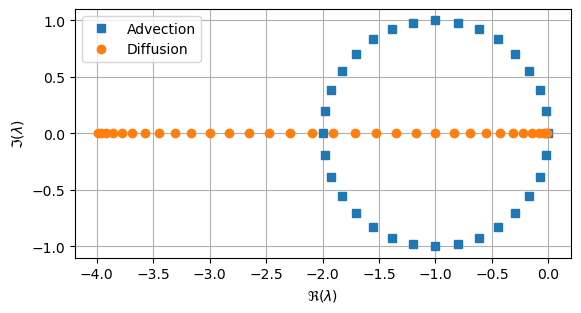

In [4]:
import numpy as np
import matplotlib.pyplot as plt

J = 32

A_adv = -finDiffMatrixD1U1(J=J, L=J)
A_diff = finDiffMatrixD2C2(J=J, L=J+1)

lamAdv = np.linalg.eigvals(A_adv)
lamDiff = np.linalg.eigvals(A_diff)

plt.plot(lamAdv.real, lamAdv.imag, 's', label='Advection')
plt.plot(lamDiff.real, lamDiff.imag, 'o', label='Diffusion')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', 'box')
plt.xlabel(r'$\Re(\lambda)$'), plt.ylabel(r'$\Im(\lambda)$');

Eigenvalues for diffusion are all negative real, which indicate an exponential decay in all component of the solution over time.

For advection, eigenvalues have an imaginary part, which indicate the oscillating behavior typical to periodic advection : after one period, the solution comes back to its original initial state, and so one after each time period.
But the eigenvalues also have a negative real part, that shows the **artificial dissipation brought by the Upwind numerical scheme**.

> **To go further :** implement the `finDiffMatrixD1C2` that build the finite difference matrix for the centered second order finite difference scheme for the first space derivative, and check that it does not induce any numerical dissipation ? 


### Full Space-Time Discretization

We now consider two time-discretization schemes to solve the system of (eventually non-homogeneous) ODE :

- Backward Euler
- Forward Euler

We investigate the combination of those space-time discretization method using an approach allowing to analyze both stability and accuracy.

Just for the homogeneous ODE, we can write one step of Forward Euler like this :

$$
{\bf u}_{num}(t + \Delta{t}) = (I + \Delta{t}A){\bf u}_{num}(t)
$$

while one step of Backward Euler can be written as :

$$
{\bf u}_{num}(t + \Delta{t}) = (I - \Delta{t}A)^{-1}{\bf u}_{num}(t)
$$

So more generally, we can write the time-stepping method like this :

$$
{\bf u}_{num}(t + \Delta{t}) = M{\bf u}_{num}(t)
$$

with $M$ depending on the time integration method, the $A$ matrix and the time-step $\Delta{t}$.
Let us use that to quickly compute the numerical solution for advection on a few Forward Euler time-steps with $\Delta{t}=1$ :

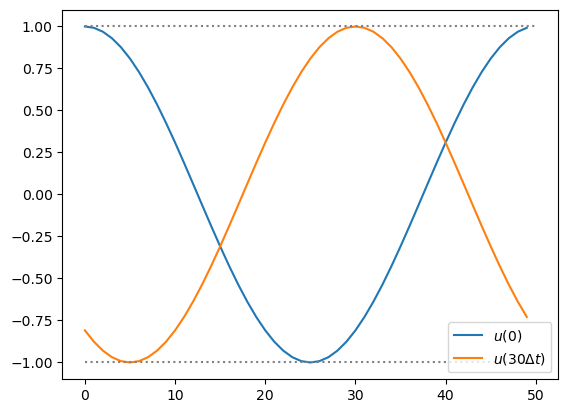

In [5]:
J = 50
I = np.eye(J)
dt = 1
A_adv = -finDiffMatrixD1U1(J=J, L=J)
M = I + dt*A_adv

u0 = np.cos(2*np.pi*np.linspace(0, 1, J, endpoint=False))

nSteps = 30
ut = u0
for i in range(nSteps):
    ut = M @ ut

plt.plot(u0, label="$u(0)$")
plt.plot(ut, label=f"$u({nSteps}\Delta""{t})$")
plt.hlines([-1, 1], 0, J, linestyles=":", colors="gray")
plt.legend();

Now if we look at the $M$ matrix itself, in particular its eigenvalues, we get :

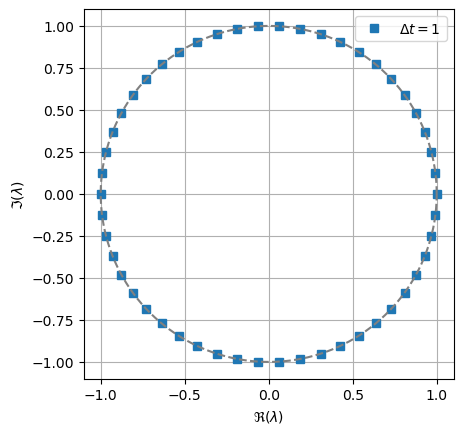

In [6]:
lamM = np.linalg.eigvals(M)
plt.plot(lamM.real, lamM.imag, 's', label=r'$\Delta{t}=1$')
circle = np.exp(2j*np.pi*np.linspace(0, 1, 500))
plt.plot(circle.real, circle.imag, '--', c='gray')

plt.legend()
plt.grid()
plt.gca().set_aspect('equal', 'box')
plt.xlabel(r'$\Re(\lambda)$'), plt.ylabel(r'$\Im(\lambda)$');

$\Rightarrow$ they are all distributed on the unit circle, which indicate that time-integration is "exact" for components of the solution. This is a particularity of Forward Euler with first order Upwind for periodic advection, which is exact as soon as $CFL=\frac{\Delta{t}}{\delta{x}}=1$, which is the case here.

Now, let us look at different time-step sizes but simulate until the same computation time :

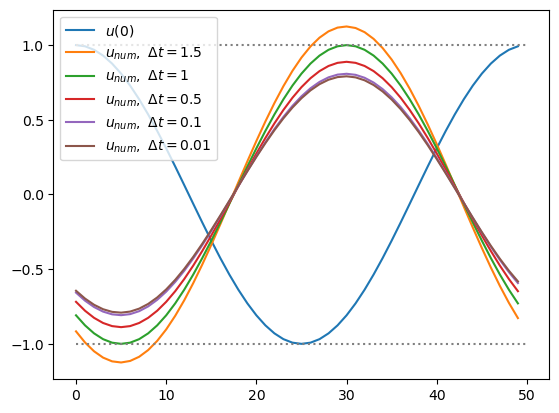

In [7]:
plt.plot(u0, label="$u(0)$")

T = 30
for dt in [1.5, 1, 0.5, 0.1, 0.01]:
    nSteps = int(round(T/dt))
    M = I + dt*A_adv
    ut = u0
    for i in range(nSteps):
        ut = M @ ut
    plt.plot(ut, label="$u_{num},~\Delta{t}="f"{dt}$")

plt.hlines([-1, 1], 0, J, linestyles=":", colors="gray")
plt.legend();

We observe that using a smaller time-step induces some diffusion in the solution, while a larger time-step induces an amplification that would result in a numerical instability later, as the numerical solution would continue growing.

Now let use look at the eigenvalues of the $M$ matrix for each time-steps :

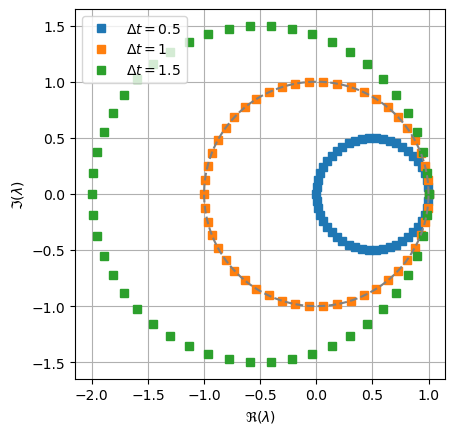

In [8]:
I = np.eye(J)

for dt in [0.5, 1, 1.5]:
    M = I + dt*A_adv
    lamM = np.linalg.eigvals(M)
    plt.plot(lamM.real, lamM.imag, 's', label='$\Delta{t}='f"{dt}$")

circle = np.exp(2j*np.pi*np.linspace(0, 1, 500))
plt.plot(circle.real, circle.imag, '--', c='gray')

plt.legend()
plt.grid()
plt.gca().set_aspect('equal', 'box')
plt.xlabel(r'$\Re(\lambda)$'), plt.ylabel(r'$\Im(\lambda)$');

As the eigenvalues for $\Delta{t}=1$ are distributed along the unitary circle, we observe two other situations for the other time-step sizes :

- $\Delta{t}=0.5$ : eigenvalues are strictly inside the unit circle, which indicates **numerical dissipation in all component of the solution**, hence some diffusion error.
- $\Delta{t}=1.5$ : eigenvalues are strictly outside the unit circle, which indicates **numerical amplification in all component of the solution**, hence numerical instability.

So we get back the classical result obtained from the Von-Neumann analysis with the CFL number, in addition of getting more information on the how the space-time discretization acts on each of the solution component.

This can be investigate by looking at the eigenvalues of the matrix to the power 1, 2, 3, ... representing the evolution of the solution components after 1, 2, 3 ... time-steps.

For instance, considering $\Delta{t}=1$ :

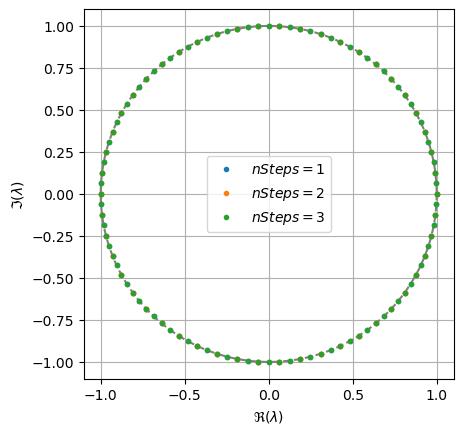

In [9]:
def plotEigenvalues(M, nSteps=3, legendLoc=None):
    S = np.eye(*M.shape)
    circle = np.exp(2j*np.pi*np.linspace(0, 1, 500))
    plt.plot(circle.real, circle.imag, '--', c='gray')
    for nStep in range(nSteps):
        S = S @ M
        lamS = np.linalg.eigvals(S)
        plt.plot(lamS.real, lamS.imag, '.', label=rf'$nSteps={nStep+1}$')
    plt.legend(loc=legendLoc)
    plt.grid()
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel(r'$\Re(\lambda)$'), plt.ylabel(r'$\Im(\lambda)$')

dt = 1
J = 100
M = np.eye(J) - dt*finDiffMatrixD1U1(J=J, L=J)

plotEigenvalues(M)

$\Rightarrow$ each eigenvalues are located on the unit circle, and doing one time-step only rotate the eigenvalue around the origin, such that it takes the place of an eigenvalue from the previous time-step.

Now considering a smaller time-step :

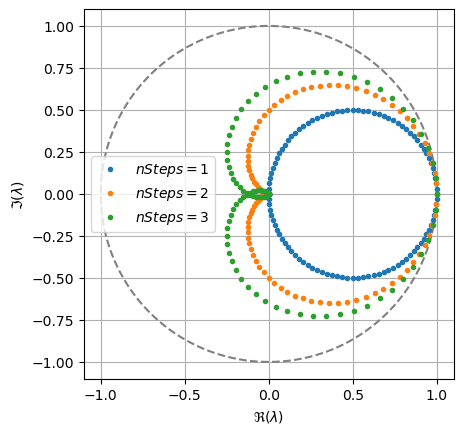

In [10]:
dt = 0.5
J = 100
M = np.eye(J) - dt*finDiffMatrixD1U1(J=J, L=J)
plotEigenvalues(M)

Here eigenvalues close to 1 (low frequency components of the solution) are rotated around the origin, and stays close to the unit circle, while eigenvalues close to 0 (high frequency components) are quickly move toward the origin.
This illustrate that low frequency components are dissipated during simulation, but higher frequency component are dissipated even faster.

Now considering a larger time-step :

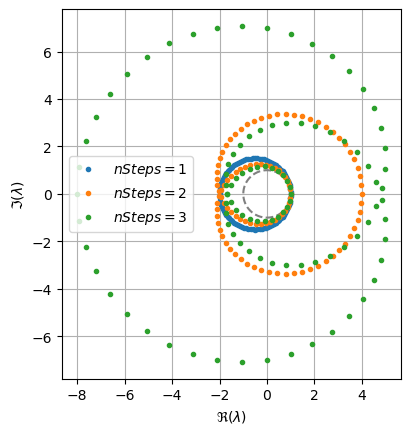

In [11]:
dt = 1.5
J = 100
M = np.eye(J) - dt*finDiffMatrixD1U1(J=J, L=J)
plotEigenvalues(M)

Here we see that amplitude of each eigenvalues is amplified. While it is moderate for eigenvalues close to 1 (low frequency component), it is very fast for eigenvalues originally located close to -2 for the first iteration (high frequency component). This indicates that numerical instability is even larger for high frequency component. And even if they are not present in the initial solution (we considered only a cosine with period $L$ for now), they are **present in the solution up to machine precision**, which will eventually make the instability appear after sufficient number of time-steps.

Now if we use the Backward Euler method, and plot the eigenvalues after the first time-steps with $\Delta{t} = 1.5$

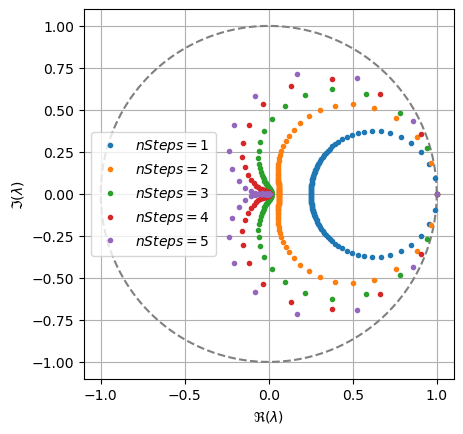

In [12]:
dt = 1.5
J = 100
M = np.linalg.solve(np.eye(J) + dt*finDiffMatrixD1U1(J=J, L=J), np.eye(J))
plotEigenvalues(M, nSteps=5)

As expected, each eigenvalue stays in the unit circle, as Backward Euler is unconditionally stable for any time-step size. But we also see that eigenvalues originally located close to 0.25 (high frequency component) are rapidly dissipated and moved toward the origin.
This shows that to achieve unconditional stability, Backward Euler actually dissipate high-frequency components, and the larger the time-step, the faster those components are dissipated :

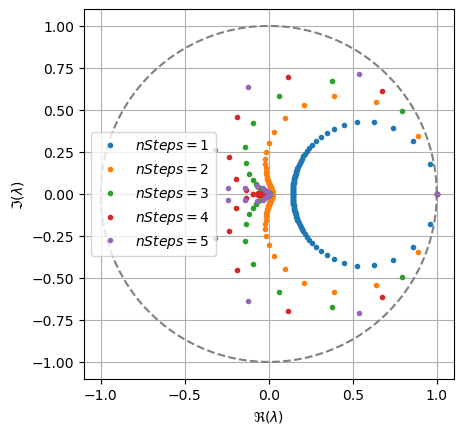

In [13]:
dt = 3
J = 100
M = np.linalg.solve(np.eye(J) + dt*finDiffMatrixD1U1(J=J, L=J), np.eye(J))
plotEigenvalues(M, nSteps=5)

Furthermore, if we compare with Forward Euler on a smaller time step, Backward Euler actually dissipate more the high frequency components :

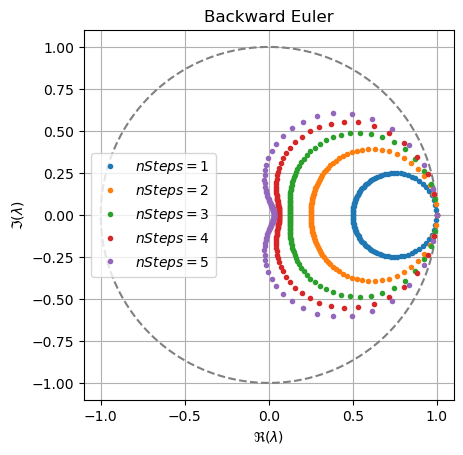

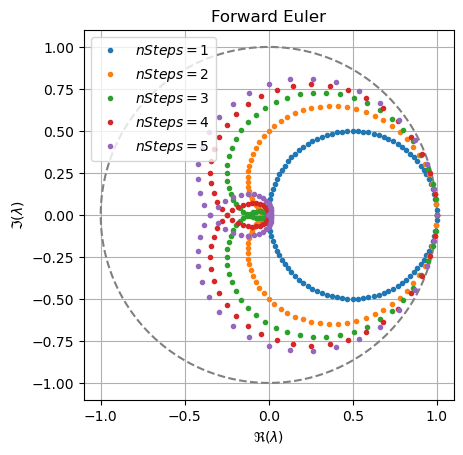

In [14]:
dt = 0.5
J = 100
M = np.linalg.solve(np.eye(J) + dt*finDiffMatrixD1U1(J=J, L=J), np.eye(J))
plt.figure()
plt.title('Backward Euler')
plotEigenvalues(M, nSteps=5)

M = np.eye(J) - dt*finDiffMatrixD1U1(J=J, L=J)
plt.figure()
plt.title('Forward Euler')
plotEigenvalues(M, nSteps=5)

Finally, we can use a similar approach to investigate space-time discretization for the heat equation

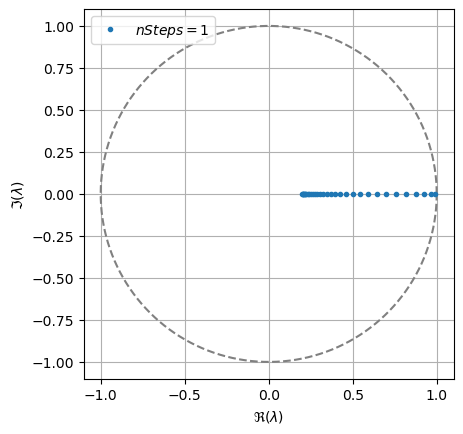

In [15]:
dt = 1
J = 32
M = np.linalg.solve(np.eye(J) - dt*finDiffMatrixD2C2(J=J, L=J+1), np.eye(J))
plotEigenvalues(M, nSteps=1, legendLoc='upper left')

For on step only, all eigenvalues are located on the real axis, with amplitude strictly lower than 1. Hence successive time-steps will simply move each eigenvalue toward the origin, and those associated to high-frequency components (close to the origin) with be dissipated faster.

Using Forward Euler and the same time-step will however "push" the high-frequency eigenvalues toward $-\infty$ and some will be out of the unit circle, inducing numerical instabilities for those eigenvalues :

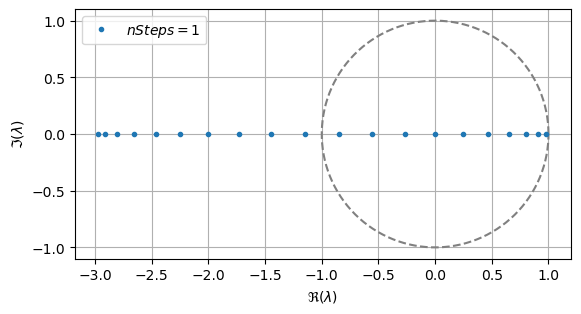

In [16]:
dt = 1
J = 20
M = np.eye(J) + dt*finDiffMatrixD2C2(J=J, L=J+1)
plotEigenvalues(M, nSteps=1)

This means that one has to reduce the time-step size in order to have a stable numerical time-integration with Forward Euler :

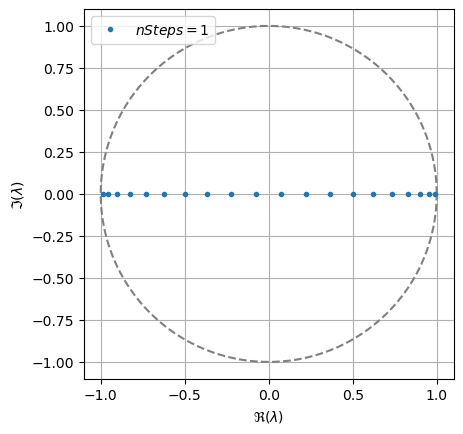

In [17]:
dt = 0.5
J = 20
M = np.eye(J) + dt*finDiffMatrixD2C2(J=J, L=J+1)
plotEigenvalues(M, nSteps=1, legendLoc='upper left')

**To go further :** how are the eigenvalues if you consider the trapeze rule, that has the following $M$ matrix :

$$M = (I + 0.5\Delta{t}A)(I - 0.5\Delta{t}A)^{-1}

### Accuracy of PDE Solvers

Now that we analyzed some properties of our space-time discretization, we can analyze their accuracy for one given problem and initial solution. For that, we provide implementation of the Forward and Backward Euler time-stepping method for solving generic problem of the form :

$$
\frac{d {\bf u}}{dt} = A {\bf u}(t) + {\bf b}(t)
$$

To illustrate this, we show the numerical solution of advection and heat equation for a Gaussian initial solution, using several steps of Backward Euler :

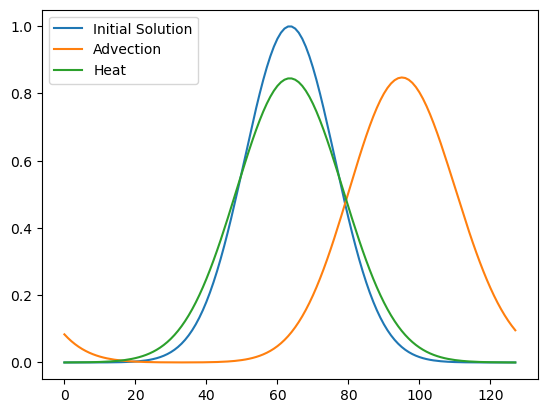

In [18]:
from pde import backwardEulerLin, forwardEulerLin

J = 128
u0 = np.exp(-np.linspace(-J/2, J/2, num=J)**2/(J**2/50))
plt.plot(u0, label='Initial Solution')

A_adv = -finDiffMatrixD1U1(J=J, L=J)
A_diff = finDiffMatrixD2C2(J=J, L=J)

times, u_adv = backwardEulerLin(A_adv, u0, b=lambda t: 0, tBeg=0, tEnd=J/4, N=J//4)
plt.plot(u_adv[:, -1], label="Advection")

times, u_diff = backwardEulerLin(A_diff, u0, b=lambda t: 0, tBeg=0, tEnd=J/4, N=J//4)
plt.plot(u_diff[:, -1], label="Heat")
plt.legend();


We can observe that some error for the advection, as the space-time discretization induces some visible diffusion error in the solution. We can also guess that there is something similar for the heat equation. This error depends not only on $\Delta{t}$, but also on $\Delta{x}$.

First, we evaluate the **global truncation error in time (only)** using the following procedure :

1. Set a given $L$, $J$ and $T$
2. Choose a large $N_{ref}$ for the reference solution
3. For increasing $N << N_{ref}$, such that $N$ is a divider of $N_{ref}$: 
    1. Compute the solution until $T$
    2. Compute the $L_\infty$ error in space and time with the reference solution, restricted to the $N$ time steps
4. Plot the error in function of $N$

We define a function that computes and shows the time discretization error for advection and Forward Euler, and use it

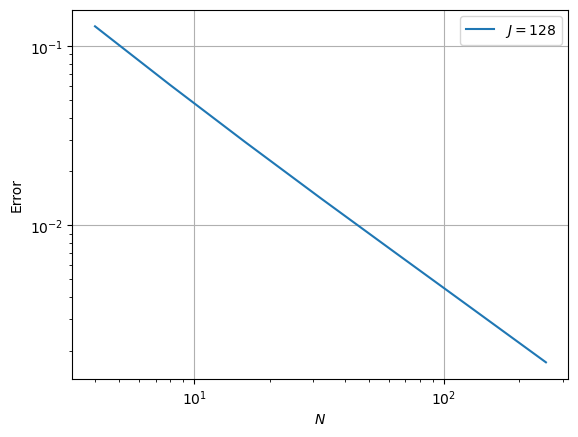

In [19]:
def plotTimeError(L=1, J=128, tEnd=0.1):

    x = np.linspace(-L/2, L/2, num=J, endpoint=False)
    u0 = np.exp(-x**2 * 50)

    A = -finDiffMatrixD1U1(J, L)

    N_ref = 2**14
    _, u_ref = forwardEulerLin(A, u0, b=lambda t: 0, tBeg=0, tEnd=tEnd, N=N_ref)

    nSteps = 2**np.arange(2, 9)
    err = []
    for N in nSteps:
        _, u = forwardEulerLin(A, u0, b=lambda t: 0, tBeg=0, tEnd=tEnd, N=N)
        ref = u_ref[:, ::N_ref//N]
        err.append(np.linalg.norm(np.linalg.norm(u-ref, ord=np.inf, axis=-1), ord=np.inf))

    plt.loglog(nSteps, err, label=f"$J={J}$")
    plt.xlabel('$N$')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plotTimeError()

As expected, we observe that the error decreases with order one, following the global truncation error of Forward Euler. Changing $J$ provides similar error curves, that differs mostly with the error constant.

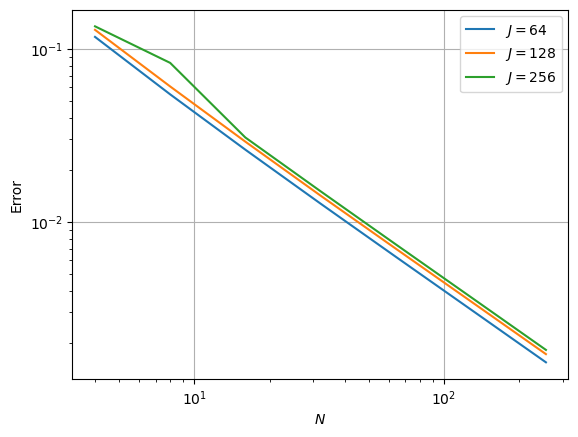

In [20]:
plotTimeError(J=64)
plotTimeError(J=128)
plotTimeError(J=256)

However, we only showed error in time here, ignoring first the error done by the space discretization. In order to correctly choose the time-step size that put the time-discretization error to the same level as the space error, we have then to evaluate this last one.

To do that, we suggest to use an exact time-integration for our problem, using matrix exponential.
For the generic system of ODE, the solution is :

$$
{\bf u}(t) = \exp(tA)\left[{\bf u}_0 + \int_0^{t} \exp(-sA){\bf f}(s)ds\right],
$$

which can be simplified for an homogeneous problem :

$$
{\bf u}(t) = \exp(tA){\bf u}_0,
$$

So we use this to estimate the space-discretization error at $t=0.1$ :

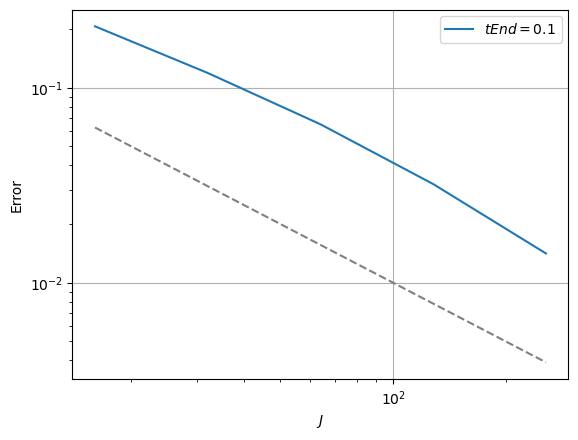

In [21]:
from scipy.linalg import expm

def plotSpaceError(L=1, tEnd=0.1):

    J_ref = 2**10
    x = np.linspace(-L/2, L/2, num=J_ref, endpoint=False)
    u0 = np.exp(-x**2 * 50)
    A = -finDiffMatrixD1U1(J_ref, L)

    u_ref = expm(tEnd*A) @ u0

    sizes = 2**np.arange(4, 9)
    err = []
    for J in sizes:
        x = np.linspace(-L/2, L/2, num=J, endpoint=False)
        u0 = np.exp(-x**2 * 50)
        A = -finDiffMatrixD1U1(J, L)
        u = expm(tEnd*A) @ u0
        ref = u_ref[::J_ref//J]
        err.append(np.linalg.norm(u-ref, ord=np.inf))

    plt.loglog(sizes, err, label=f"$tEnd={tEnd}$")
    plt.loglog(sizes, 1/sizes, '--', c='gray')
    plt.xlabel('$J$')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plotSpaceError()

We observe that the error is order 1, as expected from the first order upwind discretization. Also, we can see that to get an error below $1e^{-2}$, we need at least $J \simeq 300$.
Then looking at the time discretization error for $J=300$, we can determine the time-step size allowing to get time discretization error below $1e^{-2}$, which is obtained for $N=50$.


Now we know how to choose the space-discretization settings to solve the PDE on a given simulation period, with a chosen error tolerance.
This aspect is essential later for many iterative PinT algorithm to estimate when one should stop iterating, once the PinT error reach the error tolerance set for the solver.

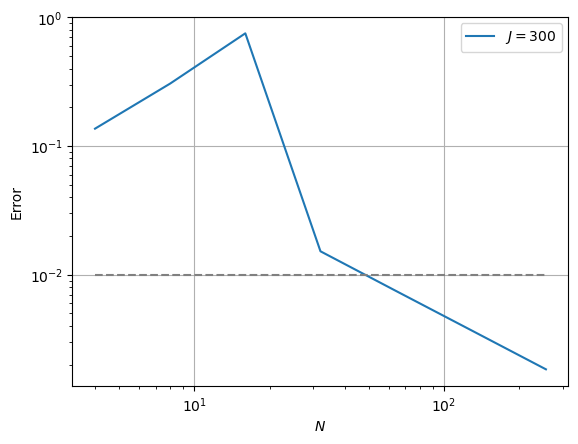

In [22]:
plotTimeError(J=300)
plt.hlines(1e-2, 4, 2**8, linestyles='--', colors='gray')

**To go further :** perform the same analysis for advection and heat equation using Backward Euler.